In [ ]:
from mesa import Agent, Model

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
from mesa.space import MultiGrid
from mesa.time import RandomActivation, BaseScheduler
from mesa.datacollection import DataCollector

In [ ]:
import numpy as np
import matplotlib.colors
import random
import math

In [ ]:

# class for agents (passengers)

class Passenger(Agent):

    def __init__(self, unique_id, model, max_speed, seat_original):
        super().__init__(unique_id, model)
        self.max_speed = max_speed
        self.speed = max_speed
        self.remaining_steps = 0
        self.original_pos = seat_original
        
        # counter of the steps necessary to exit the aircraft
        self.tot_steps = 0
        
    # function that let the agents move - Boeing 737    
    def move_737(self):

        # If the agent still has remaining steps, do nothing
        if self.remaining_steps > 0:
            self.remaining_steps -= 1
            return

        # Define possible steps based on current position
        x, y = self.pos
        possible_steps = []
        
        # check if agent is in the top cell before the exit
        if (x, y) == (0, 3):
            possible_steps.append((x, y))
        
        # if not before the exit, calculate possible steps based on specified strategy
        else:
            # front to back strategy --> passengers can move once the seats of the row in front is empty
            if self.model.strategy == "front_back":
                occ_prev = self.model.count_agents_in_row(self.model.grid, x-1, False)
                if occ_prev == 0:
                    if y == 3:
                        possible_steps.append((x-1, y))
                    elif y > 3:
                        possible_steps.append((x, y-1))
                    else:
                        possible_steps.append((x, y+1))
                else:
                    possible_steps.append((x, y))

            # back to front strategy --> passengers can move once the seats of the row behind are empty
            elif self.model.strategy == "back_front":
                try: occ_prev = self.model.count_agents_in_row(self.model.grid, x+1)
                except: occ_prev = 0
                if y == 3:
                    possible_steps.append((x-1, y))

                else:
                    if occ_prev != 0:
                        possible_steps.append((x, y))
                    else:
                        
                        if y > 3:
                            possible_steps.append((x, y-1))
                        elif y<3:
                            possible_steps.append((x, y+1))
            
            # reverse pyramid strategy --> passengers are assigned to groups based on this strategy and each group can move when the seats of previous group are empty
            elif self.model.strategy == "reverse pyramid":
                group1 = [seat for seat in self.model.seats if (seat[0] <= 14 and (seat[1] == 2 or seat[1] == 4))]
                group2 = [seat for seat in self.model.seats if (seat[0] >= 15 and (seat[1] == 2 or seat[1] == 4)) or (seat[0] <= 8 and (seat[1] == 1 or seat[1] == 5))]
                group3 = [seat for seat in self.model.seats if ((seat[0] >= 9 and seat[0] <= 16) and (seat[1] == 1 or seat[1] == 5)) or (seat[0] <= 8 and (seat[1] == 0 or seat[1] == 6))]
                group4 = [seat for seat in self.model.seats if (seat[0] >= 17 and (seat[1] == 1 or seat[1] == 5)) or ((seat[0] >= 9 and seat[0] <= 14) and (seat[1] == 0 or seat[1] == 6))]
                group5 = [seat for seat in self.model.seats if seat[0] >= 15 and (seat[1] == 0 or seat[1] == 6)]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        
                        if self.original_pos in group1:  
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group2) > 0:
                        
                        if self.original_pos in group2: 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    
                    elif len(group3) > 0:
                        
                        if self.original_pos in group3: 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group4) > 0:
                        
                        if self.original_pos in group4 : 
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    else:
                        
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))

            
            # wilma strategy --> passengers are divided in three groups (aisle, middle, window). The first to move are the passengers in the aisle seats 
            elif self.model.strategy == "wilma":
                
                group1 = [seat for seat in self.model.seats if seat[1] == 2 or seat[1] == 4]
                group2 = [seat for seat in self.model.seats if seat[1] == 1 or seat[1] == 5]
                group3 = [seat for seat in self.model.seats if seat[1] == 0 or seat[1] == 6]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        
                        if y == 2 or y == 4:
                            if y == 2:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                                
                    elif len(group2) > 0:
                        
                        if y == 1 or y == 5 or y == 2 or y == 4:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            possible_steps.append((x, y))
                        
                    elif len(group3) > 0:
                        if y == 0 or y == 6 or y == 1 or y == 5 or y == 2 or y == 4:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            possible_steps.append((x, y))

            # blocks strategy --> passengers are divided in groups. They can move once the previous group's seats are empty
            elif self.model.strategy == "blocks":
                
                group1 = [seat for seat in self.model.seats if seat[0] < 5]
                group2 = [seat for seat in self.model.seats if seat[0] >= 5 and seat[0] < 10]
                group3 = [seat for seat in self.model.seats if seat[0] >= 10 and seat[0] < 15]
                group4 = [seat for seat in self.model.seats if seat[0] >= 15 and seat[0] < 20]
                group5 = [seat for seat in self.model.seats if seat[0] >= 20 and seat[0] < 26]
                group6 = [seat for seat in self.model.seats if seat[0] >= 26]
                
                
                if y == 3:
                    possible_steps.append((x-1, y))
                
                else:
                    if len(group1) > 0:
                        if x < 5:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))

                    elif len(group2) > 0:   
                        if x >= 5 and x < 10:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                        
                    elif len(group3) > 0:
                        if x >= 10 and x < 15:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                            
                    elif len(group4) > 0:
                        if x >= 15 and x < 20:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                    
                    elif len(group5) > 0:
                        if x >= 20 and x < 26:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                        else:
                            if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                if y < 3:
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))  
                            else:        
                                possible_steps.append((x, y))
                    
                    else:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))    
              
            
            # steffen strategy --> first the passengers in odd_rows can move, then the passengers in even_rows            
            elif self.model.strategy == "steffen":
                even_rows = [seat for seat in self.model.seats if seat[0]%2 == 0]   
                odd_rows = [seat for seat in self.model.seats if seat[0]%2 != 0]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                else:
                    if len(odd_rows) > 0:
                        if x%2 != 0:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                    else:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))
            
            # adjusted steffen strategy --> passengers are divided in groups based on the row of their seats. 
            elif self.model.strategy == "adjusted steffen":
                group1 = [seat for seat in self.model.seats if seat[0] == 0 or seat[0]%3 == 0]   
                group2 = [seat for seat in self.model.seats if seat[0] == 1 or seat[0]%3 == 1]
                group3 = [seat for seat in self.model.seats if seat[0] == 2 or seat[0]%3 == 2]
                
                if y == 3:
                    possible_steps.append((x-1, y))
                else:
                    if len(group1) > 0:
                        if x == 0 or x%3 == 0:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                            
                    elif len(group2) > 0:
                        if x == 1 or x%3 == 1:
                            if y < 3:
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y))
                    
                    elif len(group3) > 0:
                        if y < 3:
                            possible_steps.append((x, y+1))
                        else:
                            possible_steps.append((x, y-1))
                        
                    
            # random strategy
            else:
                if y == 3:    
                    possible_steps.append((x-1, y))
                elif y > 3:
                    possible_steps.append((x, y-1))
                else:
                    possible_steps.append((x, y+1))

            
        # Update walking speed based on number of agents in the in the aisle and in the aircraft --> exponential increase in speed
        num_agents = len(self.model.schedule.agents)
        tot_agents = self.model.num_agents
        aisle_agents = self.model.count_agents_in_column_before_row(self.model.grid, x)
        max_aisle_agents = 64
        
        # at the beggining passengers' speed is lower because the aircraft is over-crowded
        if  y == 3:
            self.speed = self.max_speed * math.exp(-aisle_agents / max_aisle_agents)
        else:    
            self.speed = self.max_speed * math.exp(-num_agents / 100)
        
        if self.speed > self.max_speed:
            self.speed = self.max_speed
        
        
        
        # Calculate necessary steps based on agent speed - this is needed to respect passenger's speed
        if self.speed < self.max_speed:
            distance_to_travel = 0.92 # assumed cell size
            steps = math.ceil(distance_to_travel / self.speed) 
            self.remaining_steps = steps - 1
            

        # check if the adjacent cells are full
        for cell in possible_steps:
            # take the list of agents in the cell in which an agent can move to
            occupants = self.model.grid.get_cell_list_contents([cell])
            
            # if the cell is empty, the agent can move there
            if len(occupants) == 0:
                new_position = cell
                break
            
            # if the cell is occupied by one agent, the agent can move there only if that cell is in an aisle cell
            elif len(occupants) == 1:
                if cell[1] == 3: # check if passenger is in the aisle
                    new_position = cell
                    break
                else:
                    new_position = self.pos
            # if the cell has 2 agents, the agent can't move there
            elif len(occupants) == 2:
                new_position = self.pos
                break
        
        # if there are no possible steps, the agent stays in the same cell
        if len(possible_steps)==0:
            new_position = self.pos
        
        # move the agent to the new position
        self.model.grid.move_agent(self, new_position)  # <-- move there

    
    # function that let the agents move - Boeing 777
    def move_777(self):
        
        # If the agent still has remaining steps, do nothing
        if self.remaining_steps > 0:
            self.remaining_steps -= 1
            return
        
        # Define possible steps based on current position
        x, y = self.pos
        possible_steps = []
        
        
        # create groups based on seats class
        first_class = [seat for seat in self.model.seats if seat[0] < 2]
        business_class = [seat for seat in self.model.seats if seat[0] >= 2 and seat[0] < 8]
        economy_class = [seat for seat in self.model.seats if seat[0] >= 8]
        
        # calculate possible steps based on strategy
        # first the passengers in first and business class can exit, then the passengers in economy class
        
        # check if agent is in the top cell before the exit
        if (x, y) == (0, 3) or (x, y) == (0, 8):
            possible_steps.append((x, y))
        # if not before the exit, calculate possible steps based on specified strategy
        else: 
            # first, passengers in first class can move
            if len(first_class) > 0:
                if x < 2:
                    if y < 3 or (y >= 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y < 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    
                else:
                    possible_steps.append((x, y))
                
            # when first class is empty, passengers in business class can move
            elif len(business_class) > 0:
                if x < 8:
                    if y < 3 or (y > 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y <= 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))    
                        
                    
                else:
                    possible_steps.append((x, y))
            
            #when business class is empty, passengers in economy class can move
            # only the passengers in economy class must follow a strategy
            else:   
                # random strategy
                if self.model.strategy == "random":
                    if y < 3 or (y > 5 and y < 8):    
                        possible_steps.append((x, y+1))
                    elif y > 8 or (y <= 5 and y > 3):
                        possible_steps.append((x, y-1))
                    elif y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                
                # front to back strategy --> passengers can move once the seats of the row in front is empty         
                elif self.model.strategy == "front_back":
                    occ_prev = self.model.count_agents_in_row(self.model.grid, x-1, False)
                    if occ_prev == 0:
                        if y == 3 or y == 8:
                            possible_steps.append((x-1, y))
                        elif  y > 8 or (y <= 5 and y > 3):
                            possible_steps.append((x, y-1))
                        else:
                            possible_steps.append((x, y+1))
                    else:
                        possible_steps.append((x, y))
                
                # back to front strategy --> passengers can move once the seats of the row behind are empty                
                elif self.model.strategy == "back_front":
                    try: occ_prev = self.model.count_agents_in_row(self.model.grid, x+1)
                    except: occ_prev = 0
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if occ_prev != 0:
                            possible_steps.append((x, y))
                        else:
                            if  y > 8 or (y <= 5 and y > 3):
                                possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y+1))
                
                # wilma strategy, adjusted for Boeing 777 seats setting
                elif self.model.strategy == "adjusted wilma":
                    
                    group1 = [seat for seat in self.model.seats if (seat[1] == 2 or seat[1] == 9) or (seat[1] == 4 or seat[1] == 7)]
                    group2 = [seat for seat in self.model.seats if (seat[1] == 1 or seat[1] == 10) or (seat[1] == 5 or seat[1] == 6)]
                    group3 = [seat for seat in self.model.seats if seat[1] == 0 or seat[1] == 11]
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:

                        if len(group1) > 0:
                            if y == 2 or y == 9 or y == 4 or y == 7:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group2) > 0:
                            if y >= 1 and y <= 10:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))   
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group3) > 0:
                            if y >= 0 or y <= 11:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                                
                            else:
                                possible_steps.append((x, y))
                
                # steffen strategy
                elif self.model.strategy == "steffen":
                    even_rows = [seat for seat in self.model.seats if seat[0]%2 == 0]   
                    odd_rows = [seat for seat in self.model.seats if seat[0]%2 != 0]
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if len(even_rows) > 0:
                            if x%2 == 0:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                        else:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                
                # adjusted steffen strategy
                elif self.model.strategy == "adjusted steffen":
                    group2 = [seat for seat in self.model.seats if seat[0] == 9 or seat[0]%3 == 0]   
                    group3 = [seat for seat in self.model.seats if seat[0] == 10 or seat[0]%3 == 1]
                    group1 = [seat for seat in self.model.seats if seat[0] == 8 or seat[0]%3 == 2]
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    else:
                        if len(group1) > 0:
                            if x%3 == 2:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                                
                        elif len(group2) > 0:
                            if x == 1 or x%3 == 0:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                possible_steps.append((x, y))
                        
                        elif len(group3) > 0:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))
                
                # blocks strategy                
                elif self.model.strategy == "blocks":
            
                    group1 = [seat for seat in self.model.seats if seat[0] < 5]
                    group2 = [seat for seat in self.model.seats if seat[0] >= 5 and seat[0] < 10]
                    group3 = [seat for seat in self.model.seats if seat[0] >= 10 and seat[0] < 15]
                    group4 = [seat for seat in self.model.seats if seat[0] >= 15 and seat[0] < 20]
                    group5 = [seat for seat in self.model.seats if seat[0] >= 20 and seat[0] < 26]
                    group6 = [seat for seat in self.model.seats if seat[0] >= 26]
                    
                    
                    if y == 3 or y == 8:
                        possible_steps.append((x-1, y))
                    
                    else:
                        if len(group1) > 0:
                            if x < 5:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))

                        elif len(group2) > 0:   
                            if x >= 5 and x < 10:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                            
                        elif len(group3) > 0:
                            if x >= 10 and x < 15:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                                
                        elif len(group4) > 0:
                            if x >= 15 and x < 20:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                        
                        elif len(group5) > 0:
                            if x >= 20 and x < 26:
                                if y < 3 or (y > 5 and y < 8):
                                    possible_steps.append((x, y+1))
                                else:
                                    possible_steps.append((x, y-1))    
                            else:
                                if self.model.count_agents_in_row(self.model.grid, x-1) == 0:
                                    if y < 3 or (y > 5 and y < 8):
                                        possible_steps.append((x, y+1))
                                    else:
                                        possible_steps.append((x, y-1))  
                                else:        
                                    possible_steps.append((x, y))
                        
                        else:
                            if y < 3 or (y > 5 and y < 8):
                                possible_steps.append((x, y+1))
                            else:
                                possible_steps.append((x, y-1))    
                    
                            
        
                
        # Update walking speed based on number of agents in the in the aisle and in the model --> exponential increase in speed
        num_agents = len(self.model.schedule.agents)
        tot_agents = self.model.num_agents
        aisle_agents = self.model.count_agents_in_column_before_row(self.model.grid, x)
        
        if  y == 3 or y == 8:
            self.speed = self.max_speed * math.exp(-aisle_agents / 10)
        else:
            if self.original_pos in first_class:
                self.speed = self.max_speed * math.exp(-8 / 200)
            elif self.original_pos in business_class:
                self.speed = self.max_speed * math.exp(-48 / 200)
            else:    
                self.speed = self.max_speed * math.exp(-num_agents / 200)
        
        if self.speed > self.max_speed:
            self.speed = self.max_speed
                
        # Calculate necessary steps based on agent speed
        if self.speed < self.max_speed:
            distance_to_travel = 0.92 # assumed cell size
            steps = math.ceil(distance_to_travel / self.speed) 
            self.remaining_steps = steps - 1
            

        # check if the adjacent cells are full
        for cell in possible_steps:
            occupants = self.model.grid.get_cell_list_contents([cell])
            if len(occupants) == 0:
                new_position = cell
                break
                
            elif len(occupants) == 1:
                if cell[1] == 3 or cell[1] == 8: # check if passenger is in the aisle
                    new_position = cell
                    break
                else:
                    new_position = self.pos
            
            elif len(occupants) == 2:
                new_position = self.pos
                break
        
        
        if len(possible_steps)==0:
            new_position = self.pos
        
        
        self.model.grid.move_agent(self, new_position)  # <-- move there
        
        
    def step(self):
        
        if self.model.model == 737:
            self.move_737()
        else:
            self.move_777()
        

In [ ]:
class AircraftModel(Model):
    """A model with some number of agents."""
    def __init__(self, aircraft_model, age_dec = 0.2, parent_dec = 0.15, luggage_fract = 0.85, child_fract = 0.1, old_fract = 0.1, parent_fract = 0.1, strategy = 'random'):
        self.model = aircraft_model
        
        # set aircraft models settings
        if self.model == 737:
            self.num_agents = 189
            num_rows = 32
            num_seats_per_row = 7
        else:
            self.num_agents = 356
            num_rows = 38
            num_seats_per_row = 12
        
        
        self.grid = MultiGrid(num_rows, num_seats_per_row, True) # <--- we define the type of space for our model  
        
        # specified disebarking strategy
        self.strategy = strategy
        
        # agents activation
        self.schedule = RandomActivation(self)
        
        
        if self.model == 737:
            # specify the position of the seats for Boeing 737
            removed_seats = [(0,4), (0,5), (0,6)]
            self.seats = [(row, col) for row in range(num_rows) for col in range(num_seats_per_row) if col != 3 and (row,col) not in removed_seats] # seats do not include the aisle
            
        else:
            # specify the position of the seats for Boeing 777
            removed_seats = [(0, 1),(0, 2),(0, 9),(0, 10),(0, 4),(0, 7),(1, 4),(1, 7),(1, 1),(1, 2),(1, 9),(1, 10),(2, 2),(2, 9),(3, 2),(3, 9),(4, 2),(4, 9),(5, 2),(5, 9),(6, 2),(6, 9),(7, 2),(7, 9)]
            self.seats = [(row, col) for row in range(num_rows) for col in range(num_seats_per_row) if (row, col) not in removed_seats and col != 3 and col != 8] # seats do not include the aisle


        
        self.running = True
        self.lugg_fract = luggage_fract  # <--- probability of a passenger having a luggage
        self.old_fract = old_fract       # <--- probability of a passenger being old
        self.child_fract = child_fract   # <--- probability of a passenger being a child
        self.parent_fract = parent_fract # <--- probability of a passenger being a parent

        # decrease of maximum walking speed for children, elders and parents
        self.age_dec = age_dec
        self.parent_dec = parent_dec
        
        
        
        # change seats order based on the specified srategy
        if self.strategy == 'random':
            seats_order = self.seats.copy()
        elif self.strategy == 'wilma':
            seats_order = self.wilma(self.seats)
        elif self.strategy == 'reverse pyramid':
            seats_order = self.seats
        elif self.strategy == 'steffen':
            seats_order = self.steffen(self.seats)
        elif self.strategy == 'front_back':
            seats_order = self.seats.copy()
        elif self.strategy == 'back_front':
            seats_order = self.seats[::-1]
        elif self.strategy == 'blocks':
            seats_order = self.blocks(self.seats)
        elif self.strategy == 'adjusted steffen':
            seats_order = self.adj_steffen(self.seats)
        else:
            seats_order = self.seats.copy()
            
        
        # Create and add agents to the model
        for i in range(self.num_agents):
            
            # assign agent to a seat 
            seat = self.random.choice(seats_order)
            

            max_speed = 0.92 # <--- max speed of the agent in m/s
            # randomly assign a luggage to the passenger
            # passengers with luggage have lower max speed - decrease based on literature
            if random.random() < self.lugg_fract:
                # diminish max speed using normal distribution in order to have a wait of 25 seconds
                waiting = np.random.normal(loc=10, scale=8)  # mean=0.3, std=0.02
                distance_from_exit = seat[0]*0.92
                std_tot_time = distance_from_exit / max_speed
                new_tot_time = std_tot_time + waiting
                max_speed = max(0.2, std_tot_time / new_tot_time)

            # randomly assign passenger to old or child or parent category and assign corresponding max speed decrease - decrease based on model calibration
            if random.random() < self.child_fract:
                max_speed -= np.random.normal(loc=self.age_dec, scale=0.03)  
            elif random.random() < self.old_fract:
                max_speed -=  np.random.normal(loc=self.age_dec, scale=0.03) 
            elif random.random() < self.parent_fract:
                max_speed -=  np.random.normal(loc=self.parent_dec, scale=0.01)  
            
            # avoid to have too low max speed or negative max speed
            if max_speed < 0.1:
                max_speed = 0.1
                    
            # assigning to the agent max speed and seat coordinates
            a = Passenger(i, self, max_speed=max_speed, seat_original=seat)
            
            # adding agent to the model
            self.schedule.add(a)
            seats_order.remove(seat)
            self.grid.place_agent(a, seat)

        # setting data collector - it collects the removed agents at each step
        self.datacollector = DataCollector(
            model_reporters={"Agents Removed": lambda m: m.agents_removed},
            agent_reporters={},
        )

        self.running = True
        
        # counter of removed agents
        self.agents_removed = 0
     
    # step function        
    def step(self):
        # remove agents that exit the aircraft
        self.remove_agents_at_top()
        # collect data
        self.datacollector.collect(self)
        # step
        self.schedule.step()

    # remove agents that exit the aircraft  
    def remove_agents_at_top(self):
        if self.model == 737:
            top_cell = [(0, 3)] # <--- define the exit cell at the top of the aisle
        else:
            top_cell = [(0, 3), (0, 8)]
        
        for c in top_cell:
            if len(self.grid.get_cell_list_contents([c])) > 0 : # se c'è almeno un passeggero nell'ultima cella, viene fatto uscire
                
                agent = self.grid.get_cell_list_contents([c])[0]
                # remove the agent from the list of seats
                self.agents_removed += 1
                
                # remove passenger from the model
                self.grid.remove_agent(agent) # <--- here we remove just one agent at a time
                self.schedule.remove(agent)
                
                # here we remove agents from the first and business class groups
                if self.model == 777:
                    if agent.original_pos[0] < 8:
                        self.seats.remove(agent.original_pos)
                    
                    # for economy class
                    else:
                        if self.strategy == 'wilma' or self.strategy == 'adjusted wilma':
                            self.seats.remove(agent.original_pos)
                        if self.strategy == 'blocks':
                            self.seats.remove(agent.original_pos)
                        if self.strategy == 'steffen' or self.strategy == 'adjusted steffen':
                            self.seats.remove(agent.original_pos)
                
                # for the 737 model        
                else:
                    if self.strategy == 'wilma' or self.strategy == 'adjusted wilma':
                        self.seats.remove(agent.original_pos)
                    if self.strategy == 'blocks':
                        self.seats.remove(agent.original_pos)
                    if self.strategy == 'steffen' or self.strategy == 'adjusted steffen':
                        self.seats.remove(agent.original_pos)

                
        
    # support functions            
    def wilma(self, seat_list):
        new_order = []
        list1 = []
        list2 = []
        list3 = []
        for seat in seat_list:
            if seat[1] == 2 or seat[1] == 4:
                list1.append(seat)
            elif seat[1] == 1 or seat[1] == 5:
                list2.append(seat)
            else:
                list3.append(seat)
                
        new_order = list1 + list2 + list3
        return new_order
    
    def steffen(self, seat_list):
        # sort the seats based on their column and then row
        sorted_seats = sorted(seat_list, key=lambda x: (x[1], x[0]))
        
        # create two empty lists for odd and even rows
        odd_rows = []
        even_rows = []
        
        # loop through the sorted seats and add them to the corresponding row list
        for seat in sorted_seats:
            if seat[0] % 2 == 0:
                even_rows.append(seat)
            else:
                odd_rows.append(seat)
        
        # combine the odd and even rows to form the final sorted list of seats
        sorted_seats = even_rows + odd_rows
        
        return sorted_seats
    
    def adj_steffen(self, seat_list): 
        b1 = []
        b2 = []
        b3 = []

        for s in seat_list:
            if s[0] == 0 or s[0]%3 == 0:
                b1.append(s)
            elif s[0] == 1 or s[0]%3 == 1:
                b2.append(s)
            else:
                b3.append(s)

        return b1+b2+b3
    
    def blocks(self, seat_list):
        b1 = []
        b2 = []
        b3 = []
        b4 = []
        b5 = []
        b6 = []

        for s in seat_list:
            if s[0] < 5:
                b1.append(s)
            elif s[0] < 10:
                b2.append(s)
            elif s[0] < 15:
                b3.append(s)
            elif s[0] < 20:
                b4.append(s)
            elif s[0] < 26:
                b5.append(s)
            else:
                b6.append(s)

        ordered_list = b1+b2+b3+b4+b5+b6
        return ordered_list
    
    
    def count_agents_in_row(self, grid, row, Aisle=True):
        agent_count = 0
        if row < 0:
            return 0
        
        for idx, cell in enumerate(grid.grid[row]):
            if Aisle or (idx != 3 and idx != 8):
                if cell:
                    agent_count += len(cell) if isinstance(cell, list) else 1
        return agent_count

    def count_agents_in_column_before_row(self, grid, row, column=3):
        agent_count = 0
        for r in range(row):
            cell = grid.grid[r][column]
            if cell:
                agent_count += len(cell) if isinstance(cell, list) else 1
            
        return agent_count

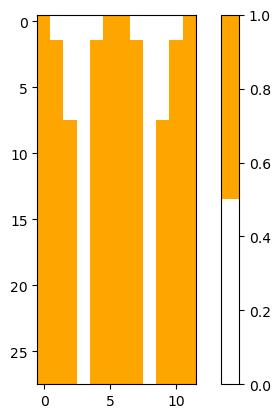

In [ ]:
model = AircraftModel(777 ,256, 28, 12)

agent_counts = np.zeros((model.grid.width, model.grid.height)) 

for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
cmap = matplotlib.colors.ListedColormap(['white', 'orange'])
plt.imshow(agent_counts, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()

777

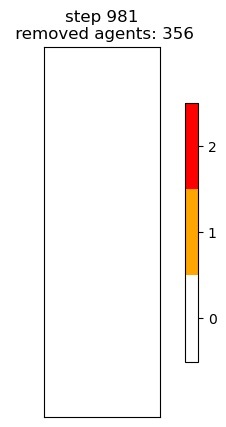

All passengers have exited the aircraft


In [ ]:
# set parameters
luggage_fract = 0.85
child_fract = 0.1
old_fract = 0.1
parent_fract = 0.1

# create the model
model = AircraftModel(777, age_dec = 0.2, parent_dec = 0.15, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy='back_front')
passengers_count = np.zeros((model.grid.width, model.grid.height)) 
removed_agents = []

# plot the initial state of the model
cmap = matplotlib.colors.ListedColormap(['white', 'orange', 'red'])
norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=2.5)
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    passenger_count = len(cell_content)
    passengers_count[x][y] = passenger_count

plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
plt.title(f'step 0\n removed agents: 0')
plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([])
plt.yticks([])
plt.show()

# plot the state of the model at each step
i = 1
while len(model.schedule.agents) > 0:
    model.step()
    i += 1
    
    removed_agents_count = model.agents_removed
    removed_agents.append(removed_agents_count)
    
    passengers_count = np.zeros((model.grid.width, model.grid.height)) 

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        passenger_count = len(cell_content)
        passengers_count[x][y] = passenger_count


    clear_output(wait=True)
    
    plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
    plt.title(f'step {i}\n removed agents: {removed_agents_count}')
    plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
    plt.tick_params(axis='both', which='both', bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

print("All passengers have exited the aircraft")

737

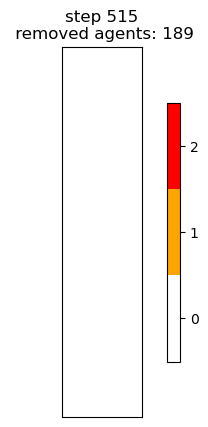

All passengers have exited the aircraft


In [ ]:
# set parameters
luggage_fract = 0.85
child_fract = 0.1
old_fract = 0.1
parent_fract = 0.1

# create the model
model = AircraftModel(737, age_dec = 0.2, parent_dec = 0.2, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy='wilma')
passengers_count = np.zeros((model.grid.width, model.grid.height)) 
removed_agents = []

# plot the initial state of the model
cmap = matplotlib.colors.ListedColormap(['white', 'orange', 'red'])
norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=2.5)
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    passenger_count = len(cell_content)
    passengers_count[x][y] = passenger_count

plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
plt.title(f'step 0\n removed agents: 0')
plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
plt.tick_params(axis='both', which='both', bottom=False, left=False)
plt.xticks([])
plt.yticks([])
plt.show()

# plot the state of the model at each step
i = 1
while len(model.schedule.agents) > 0:
    model.step()
    i += 1
    
    removed_agents_count = model.agents_removed
    removed_agents.append(removed_agents_count)
    
    passengers_count = np.zeros((model.grid.width, model.grid.height)) 

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        passenger_count = len(cell_content)
        passengers_count[x][y] = passenger_count


    clear_output(wait=True)
    
    plt.imshow(passengers_count, interpolation='nearest', cmap=cmap, norm=norm)
    plt.title(f'step {i}\n removed agents: {removed_agents_count}')
    plt.colorbar(ticks=[0, 1, 2], shrink=0.7)
    plt.tick_params(axis='both', which='both', bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()



print("All passengers have exited the aircraft")

In [ ]:
# show number of total steps for agent 0 to exit
model.datacollector.get_agent_vars_dataframe().groupby('AgentID').count()

,Total steps
AgentID,
0,1
1,14
2,12
3,18
4,15
...,...
184,585
185,611
186,590


# Models calibration

Calibration of parameters in order to reflect the real world:
- decrease of max speed in case of luggage
- decrease of max speed based on age or parent status

To do calibration we will use the random strategy.

In [ ]:
# fixed parameters
air_model = 737
child_fract = 0.1 
old_fract = 0.1
parent_fract = 0.1

# parameters to calibrate
lugg_fract=[0.85, 0.9, 0.95]
age_dec=[0.15, 0.2, 0.25, 0.3]
parent_dec=[0.05, 0.1, 0.15, 0.2]

# calibration on 1000 iterations per parameters combination

results_737 = {}

for l in lugg_fract:
    for a in age_dec:
        for p in parent_dec:
            tot_steps_count_random = []
            for n in range(500):
                model = AircraftModel(aircraft_model = air_model, age_dec=a, parent_dec=p, luggage_fract=l, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy='random')
                passengers_count = np.zeros((model.grid.width, model.grid.height)) 
                removed_agents = []
                

                i = 1
                while len(model.schedule.agents) > 0:
                    model.step()
                    i += 1
                    
                    removed_agents_count = model.agents_removed
                    removed_agents.append(removed_agents_count)

                tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
            avg = np.average(tot_steps_count_random)
            results_737[(l, a, p)] = avg


100% |########################################################################|


In [ ]:
# keep only observations between 600 and 610 from results_737
parameters_combinations = {k:v for k,v in results_737.items() if v >= 600 and v <= 610}
# save the parameters combinations in txt file
with open('calibration.txt', 'w') as f:
    print(parameters_combinations, file=f)

# Simulations

In [ ]:
random.seed(42)
strategies_737 = ['random', 'wilma', 'steffen', 'adjusted steffen', 'reverse pyramid', 'front_back', 'back_front', 'blocks']
strategies_777 = ['random', 'adjusted wilma', 'steffen', 'adjusted steffen', 'front_back', 'back_front', 'blocks']

### Boeing 737 - Scenario 1

In [ ]:
# parameters
air_model = 737
child_fract = 0.1 
old_fract = 0.1
parent_fract = 0.1

# load calibration parameters
with open('calibration.txt', 'r') as f:
    parameters_combinations = [eval(line.rstrip('\n')) for line in f]

In [ ]:
# simulation

tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_wilma = []
tot_steps_count_steffen = []
tot_steps_count_reversepyramid = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_737:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, age_dec = age_dec, parent_dec = parent_dec, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'wilma':
            tot_steps_count_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'reverse pyramid':
            tot_steps_count_reversepyramid.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

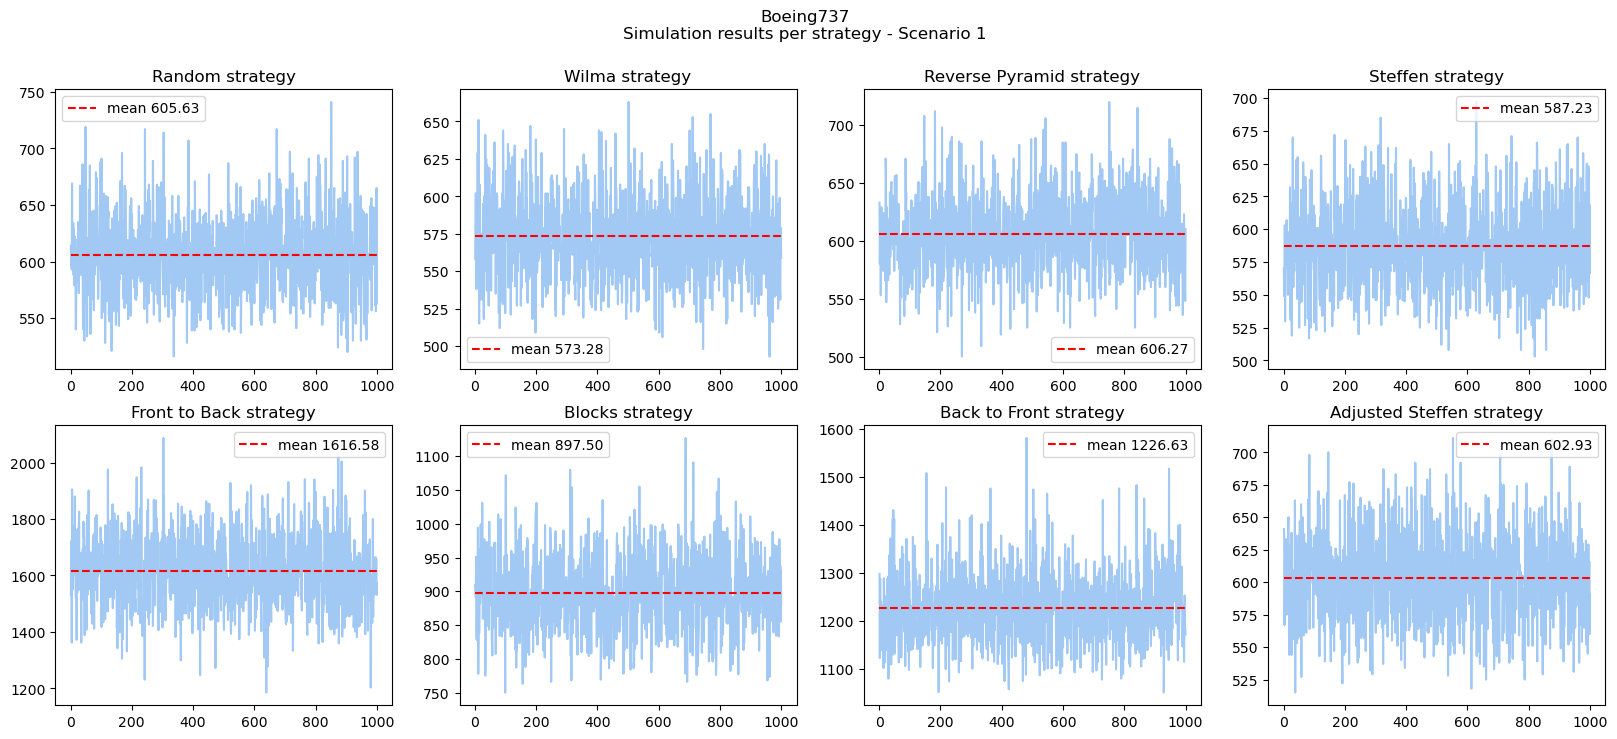

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig. suptitle("Boeing737\nSimulation results per strategy - Scenario 1")
axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_reversepyramid)
axs[0,2].hlines(np.mean(tot_steps_count_reversepyramid), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_reversepyramid):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_steffen)
axs[0,3].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_frontback)
axs[1,0].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_blocks)
axs[1,1].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_backfront)
axs[1,2].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,3].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,3].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[1,3].legend()

axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Wilma strategy')
axs[0,2].set_title('Reverse Pyramid strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');
axs[1,3].set_title('Adjusted Steffen strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_wilma_df = pd.DataFrame(tot_steps_count_wilma, columns=['steps'])
tot_steps_count_revpyramid_df = pd.DataFrame(tot_steps_count_reversepyramid, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_737 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'wilma': tot_steps_count_wilma_df['steps'], 'reverse pyramid': tot_steps_count_revpyramid_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_737.to_csv('737_sim_results.csv')
df_737

,random,wilma,reverse pyramid,steffen,front_back,by_blocks,back_front,adj_steffen
0,614,558,633,570,1531,909,1298,641
1,597,590,580,549,1656,903,1123,636
2,598,602,603,559,1723,891,1288,567
3,593,584,627,603,1362,951,1230,592
4,669,538,553,530,1905,843,1139,629
...,...,...,...,...,...,...,...,...
995,593,539,596,548,1665,888,1170,572
996,556,531,591,645,1546,938,1253,583
997,613,579,559,573,1658,855,1193,616
998,665,567,548,566,1531,930,1186,560


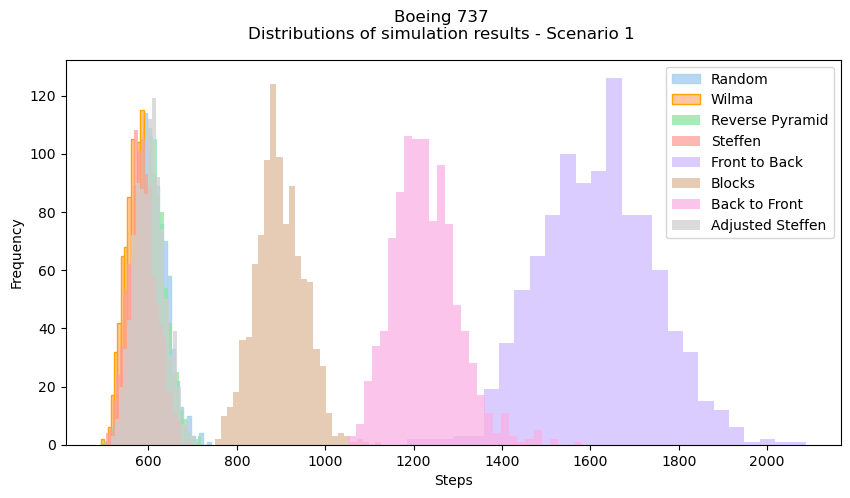

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 737\nDistributions of simulation results - Scenario 1")
sns.histplot(df_737['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_737['wilma'], kde=False, label='Wilma', edgecolor = "orange")
sns.histplot(df_737['reverse pyramid'], kde=False, label='Reverse Pyramid', edgecolor = "none")
sns.histplot(df_737['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_737['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_737['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_737['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_737['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

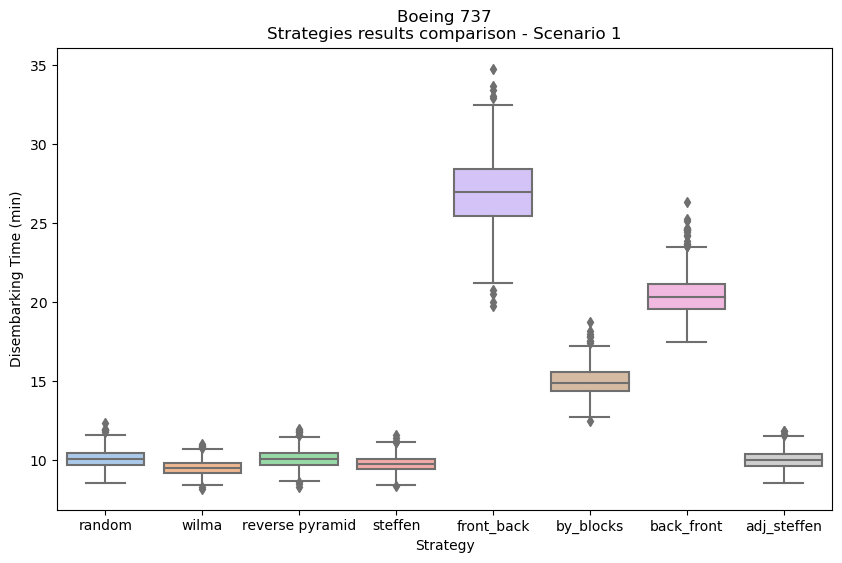

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_737/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 737\nStrategies results comparison - Scenario 1');

### Boeing 777 - Scenario 1

In [ ]:
# parameters
air_model = 777
child_fract = 0.1 
old_fract = 0.1
parent_fract = 0.1

# load calibration parameters
with open('calibration.txt', 'r') as f:
    parameters_combinations = [eval(line.rstrip('\n')) for line in f]

In [ ]:
# simulations

tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_adj_wilma = []
tot_steps_count_steffen = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_777:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'adjusted wilma':
            tot_steps_count_adj_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')
    

random: DONE
adjusted wilma: DONE
steffen: DONE
adjusted steffen: DONE
front_back: DONE
back_front: DONE
blocks: DONE


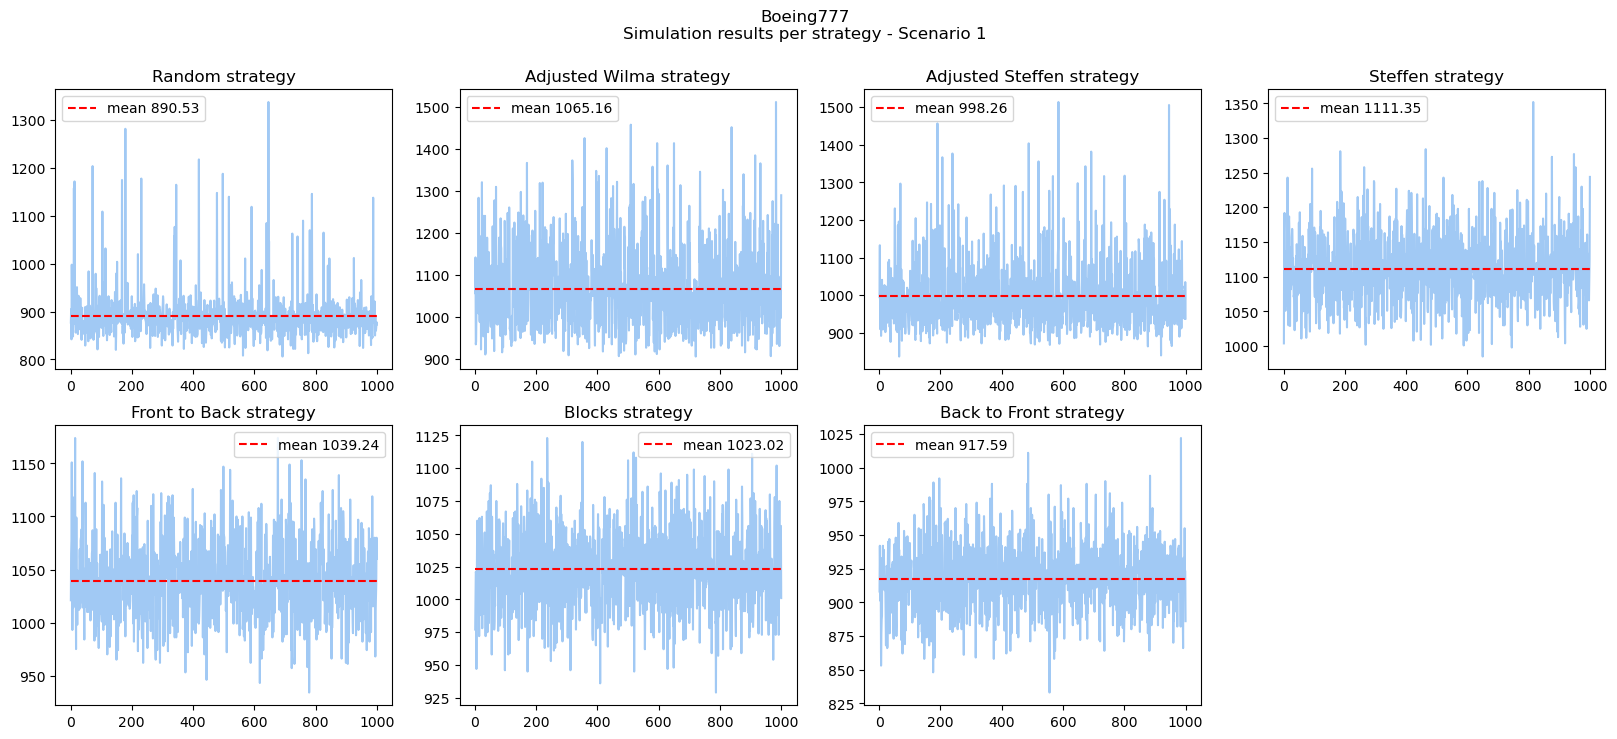

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.delaxes(axs[1,3])
fig.suptitle("Boeing777\nSimulation results per strategy - Scenario 1")

axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_adj_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_adj_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_adj_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_steffen)
axs[0,2].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_frontback)
axs[0,3].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_blocks)
axs[1,0].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_backfront)
axs[1,1].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,2].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()


axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Adjusted Wilma strategy')
axs[0,2].set_title('Adjusted Steffen strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_adj_wilma_df = pd.DataFrame(tot_steps_count_adj_wilma, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_777 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'adj_wilma': tot_steps_count_adj_wilma_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_777.to_csv('777_sim_results.csv')
df_777

,random,adj_wilma,steffen,front_back,by_blocks,back_front,adj_steffen
0,877,1056,995,1004,1021,977,908
1,905,1141,1133,1164,1065,1002,942
2,842,934,910,1192,1078,1021,924
3,998,941,943,1090,1151,1020,901
4,922,1008,1035,1102,1057,947,911
...,...,...,...,...,...,...,...
995,867,1092,952,1133,1011,1002,920
996,860,1021,937,1066,1026,1039,955
997,867,1096,946,1093,1036,1010,924
998,878,997,1035,1126,1080,1056,923


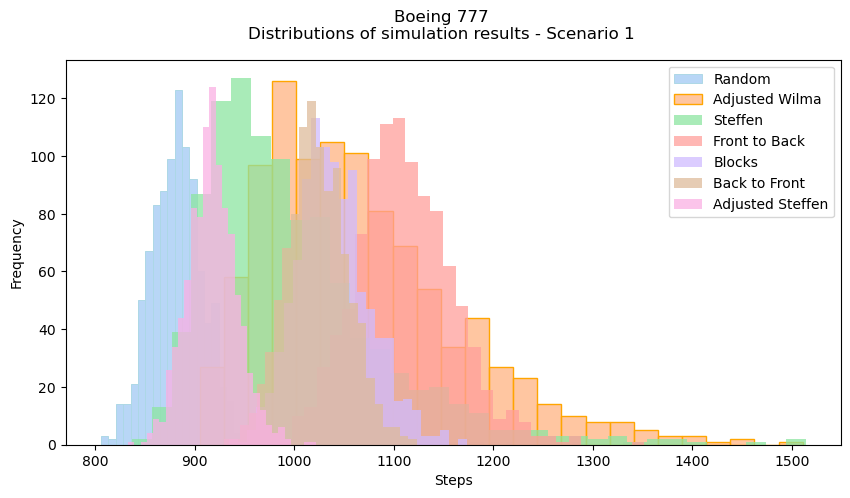

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 777\nDistributions of simulation results - Scenario 1")
sns.histplot(df_777['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_777['adj_wilma'], kde=False, label='Adjusted Wilma', edgecolor = "orange")
sns.histplot(df_777['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_777['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_777['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_777['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_777['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

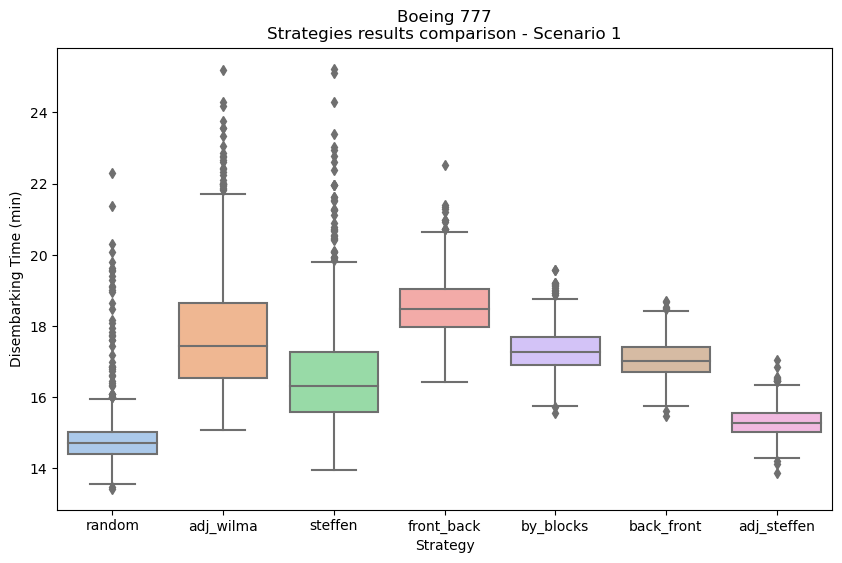

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_777/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 777\nStrategies results comparison - Scenario 1');

### Boeing 737 - Scenario 2 (higher percentage of elders and family groups)

In [ ]:
# parameters
air_model = 737

child_fract = 0.25 # <-- updated parameter
old_fract = 0.25 # <-- updated parameter
parent_fract = 0.25 # <-- updated parameter

In [ ]:
# simulation

tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_wilma = []
tot_steps_count_steffen = []
tot_steps_count_reversepyramid = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_737:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, age_dec = age_dec, parent_dec = parent_dec, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'wilma':
            tot_steps_count_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'reverse pyramid':
            tot_steps_count_reversepyramid.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

random: DONE
wilma: DONE
steffen: DONE
adjusted steffen: DONE
reverse pyramid: DONE
front_back: DONE
back_front: DONE
blocks: DONE


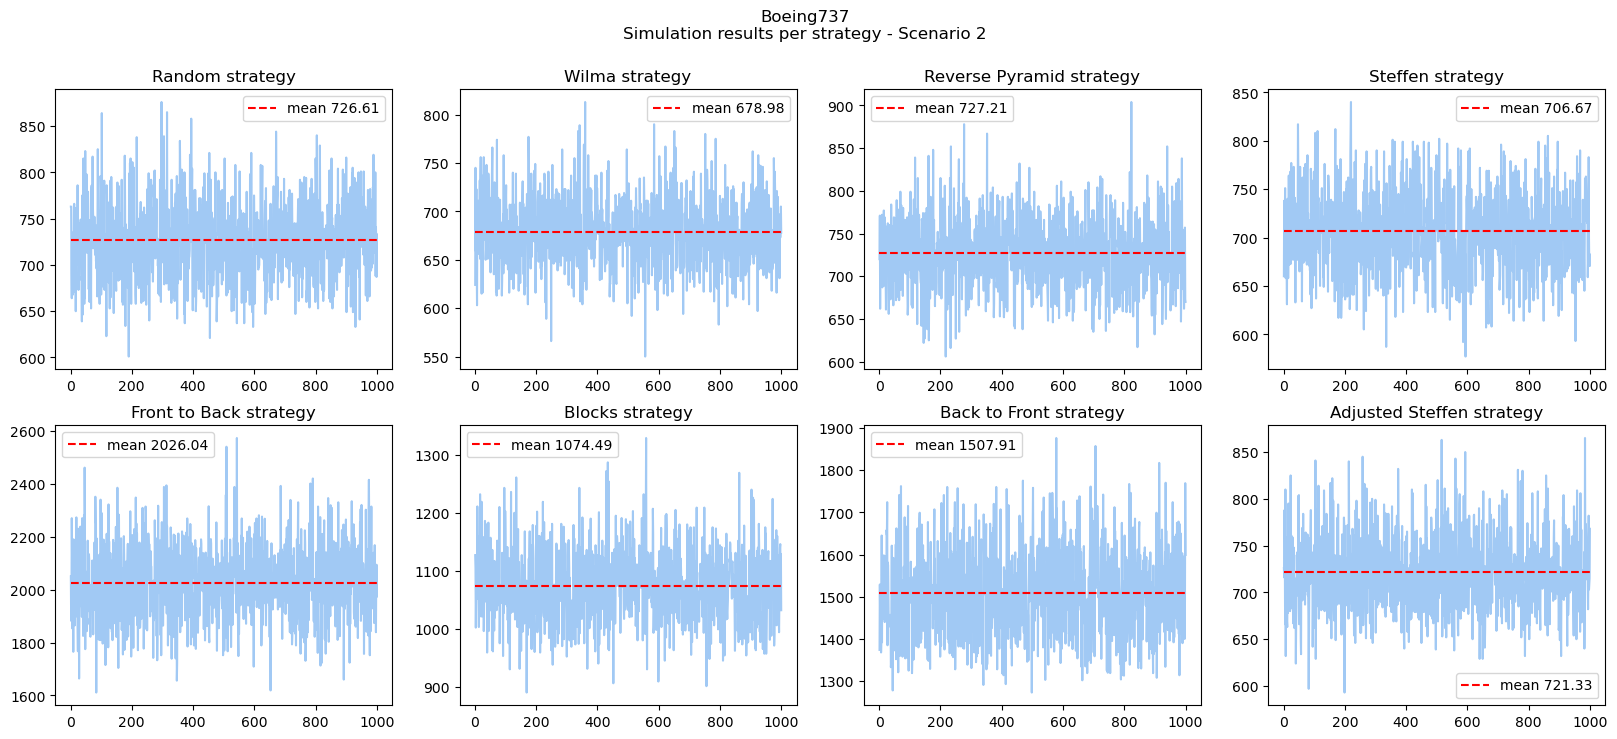

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig. suptitle("Boeing737\nSimulation results per strategy - Scenario 2")

axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_reversepyramid)
axs[0,2].hlines(np.mean(tot_steps_count_reversepyramid), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_reversepyramid):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_steffen)
axs[0,3].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_frontback)
axs[1,0].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_blocks)
axs[1,1].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_backfront)
axs[1,2].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,3].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,3].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[1,3].legend()

axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Wilma strategy')
axs[0,2].set_title('Reverse Pyramid strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');
axs[1,3].set_title('Adjusted Steffen strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_wilma_df = pd.DataFrame(tot_steps_count_wilma, columns=['steps'])
tot_steps_count_revpyramid_df = pd.DataFrame(tot_steps_count_reversepyramid, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_737_sc2 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'wilma': tot_steps_count_wilma_df['steps'], 'reverse pyramid': tot_steps_count_revpyramid_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_737_sc2.to_csv('737_sc2_sim_results.csv')
df_737_sc2

,random,wilma,reverse pyramid,steffen,front_back,by_blocks,back_front,adj_steffen
0,763,624,720,660,2050,1127,1374,726
1,763,745,771,738,1882,1105,1529,716
2,696,659,662,703,1911,1002,1451,788
3,664,692,753,715,2270,1062,1488,746
4,735,723,720,751,2125,1103,1485,666
...,...,...,...,...,...,...,...,...
995,688,697,684,783,2024,1141,1596,782
996,741,673,745,699,1839,1146,1400,703
997,723,689,757,671,2035,1069,1474,710
998,687,705,673,683,2094,1129,1769,715


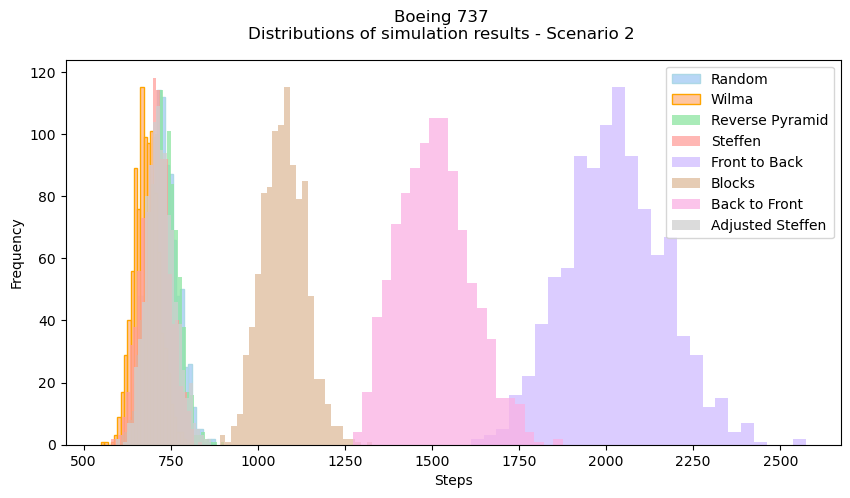

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 737\nDistributions of simulation results - Scenario 2")

sns.histplot(df_737_sc2['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_737_sc2['wilma'], kde=False, label='Wilma', edgecolor = "orange")
sns.histplot(df_737_sc2['reverse pyramid'], kde=False, label='Reverse Pyramid', edgecolor = "none")
sns.histplot(df_737_sc2['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_737_sc2['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_737_sc2['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_737_sc2['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_737_sc2['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

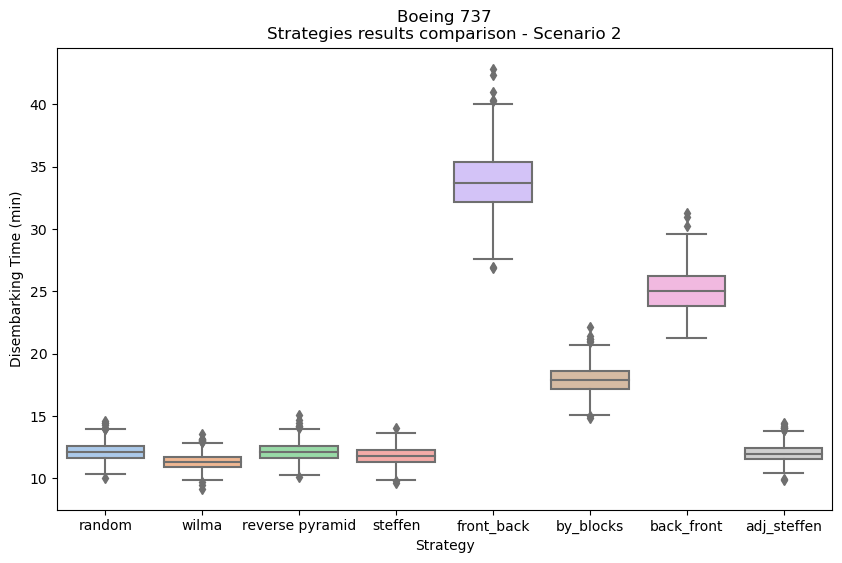

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_737_sc2/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 737\nStrategies results comparison - Scenario 2');

### Boeing 737 - Scenario 3 (higher percentage of family groups)

In [ ]:
# parameters
air_model = 737
child_fract = 0.35 # <-- updated parameter
old_fract = 0.1 
parent_fract = 0.35 # <-- updated parameter

In [ ]:
# simulation

strategies_737 = ['random', 'wilma', 'steffen', 'adjusted steffen', 'reverse pyramid', 'front_back', 'back_front', 'blocks']
tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_wilma = []
tot_steps_count_steffen = []
tot_steps_count_reversepyramid = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_737:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'wilma':
            tot_steps_count_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'reverse pyramid':
            tot_steps_count_reversepyramid.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

random: DONE
wilma: DONE
steffen: DONE
adjusted steffen: DONE
reverse pyramid: DONE
front_back: DONE
back_front: DONE
blocks: DONE


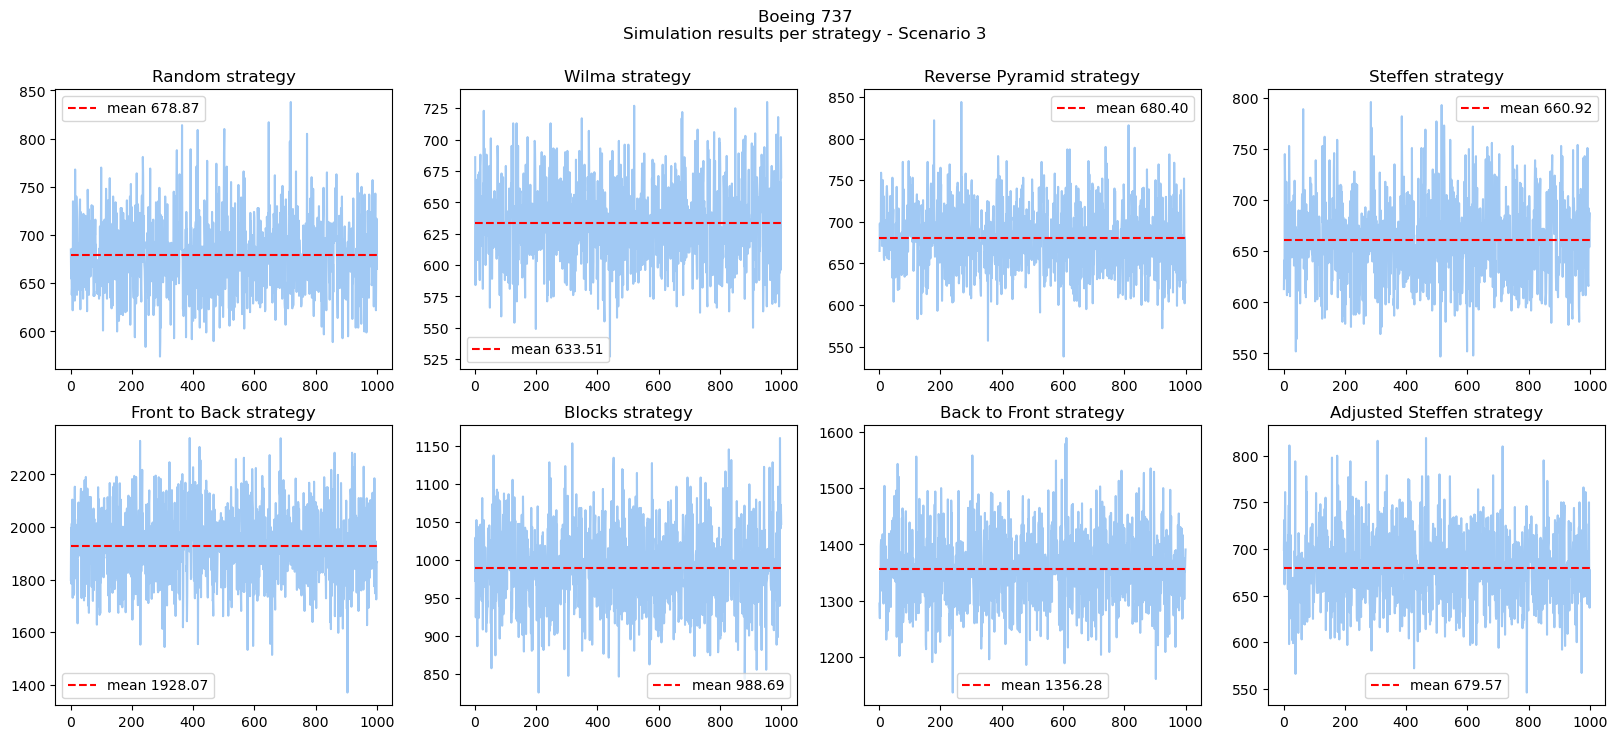

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig. suptitle("Boeing 737\nSimulation results per strategy - Scenario 3")

axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_reversepyramid)
axs[0,2].hlines(np.mean(tot_steps_count_reversepyramid), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_reversepyramid):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_steffen)
axs[0,3].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_frontback)
axs[1,0].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_blocks)
axs[1,1].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_backfront)
axs[1,2].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,3].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,3].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[1,3].legend()

axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Wilma strategy')
axs[0,2].set_title('Reverse Pyramid strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');
axs[1,3].set_title('Adjusted Steffen strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_wilma_df = pd.DataFrame(tot_steps_count_wilma, columns=['steps'])
tot_steps_count_revpyramid_df = pd.DataFrame(tot_steps_count_reversepyramid, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_737_sc3 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'wilma': tot_steps_count_wilma_df['steps'], 'reverse pyramid': tot_steps_count_revpyramid_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_737_sc3.to_csv('737_sc3_sim_results.csv')
df_737_sc3

,random,wilma,reverse pyramid,steffen,front_back,by_blocks,back_front,adj_steffen
0,685,686,665,613,1799,972,1295,699
1,655,584,698,641,1997,1029,1269,731
2,675,632,680,623,1784,924,1352,662
3,638,668,697,745,2013,978,1317,716
4,646,608,684,718,1794,1052,1397,761
...,...,...,...,...,...,...,...,...
995,656,594,681,692,1822,1160,1303,690
996,622,666,602,676,1945,1064,1354,750
997,663,596,681,654,1725,1041,1351,643
998,717,702,632,677,1868,1072,1375,637


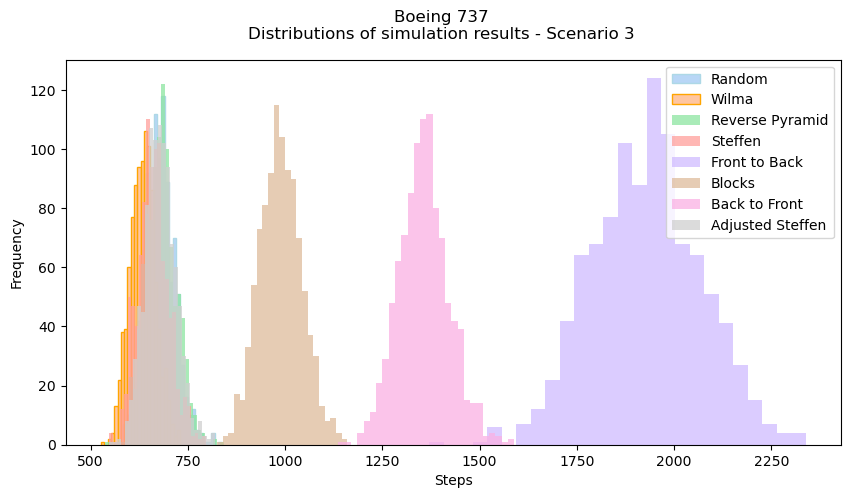

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 737\nDistributions of simulation results - Scenario 3")

sns.histplot(df_737_sc3['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_737_sc3['wilma'], kde=False, label='Wilma', edgecolor = "orange")
sns.histplot(df_737_sc3['reverse pyramid'], kde=False, label='Reverse Pyramid', edgecolor = "none")
sns.histplot(df_737_sc3['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_737_sc3['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_737_sc3['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_737_sc3['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_737_sc3['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

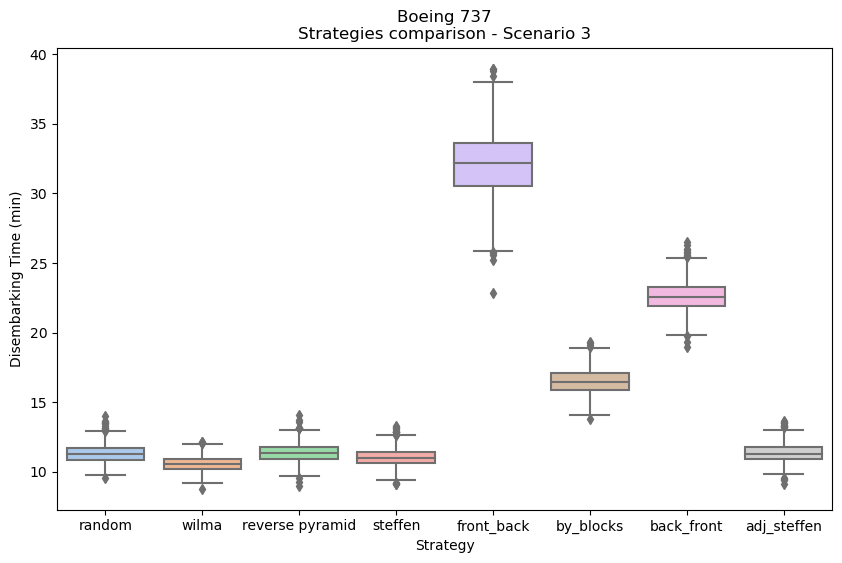

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_737_sc3/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 737\nStrategies comparison - Scenario 3');

### Boeing 737 - Scenario 4 (higher percentage of elders)

In [ ]:
# parameters
air_model = 737
child_fract = 0.1
old_fract = 0.5 # <-- updated parameter
parent_fract = 0.1

In [ ]:
# simulation

strategies_737 = ['random', 'wilma', 'steffen', 'adjusted steffen', 'reverse pyramid', 'front_back', 'back_front', 'blocks']
tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_wilma = []
tot_steps_count_steffen = []
tot_steps_count_reversepyramid = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_737:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'wilma':
            tot_steps_count_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'reverse pyramid':
            tot_steps_count_reversepyramid.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

random: DONE
wilma: DONE
steffen: DONE
adjusted steffen: DONE
reverse pyramid: DONE
front_back: DONE
back_front: DONE
blocks: DONE


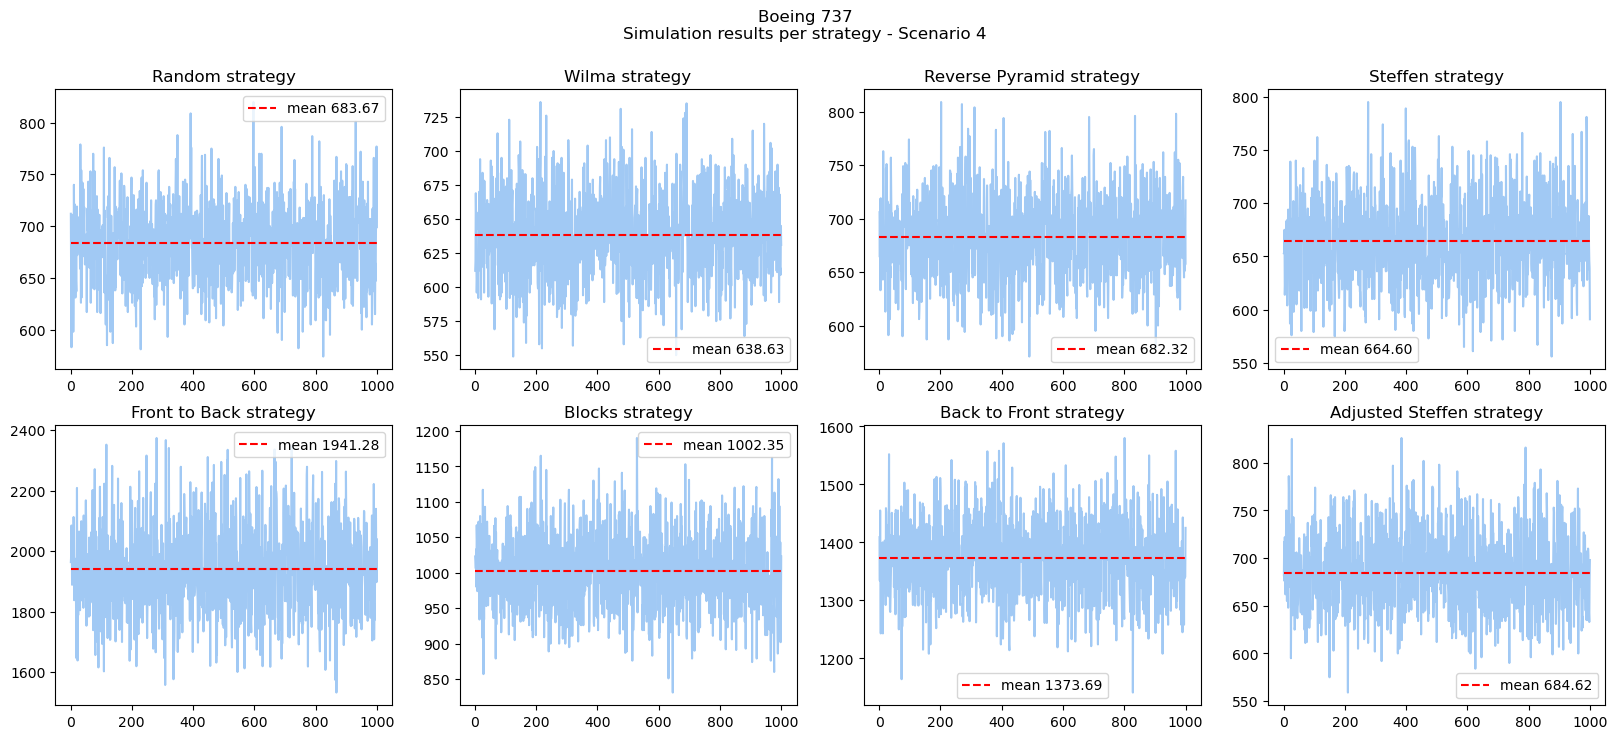

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig. suptitle("Boeing 737\nSimulation results per strategy - Scenario 4")

axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_reversepyramid)
axs[0,2].hlines(np.mean(tot_steps_count_reversepyramid), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_reversepyramid):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_steffen)
axs[0,3].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_frontback)
axs[1,0].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_blocks)
axs[1,1].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_backfront)
axs[1,2].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,3].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,3].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[1,3].legend()

axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Wilma strategy')
axs[0,2].set_title('Reverse Pyramid strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');
axs[1,3].set_title('Adjusted Steffen strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_wilma_df = pd.DataFrame(tot_steps_count_wilma, columns=['steps'])
tot_steps_count_revpyramid_df = pd.DataFrame(tot_steps_count_reversepyramid, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_737_sc4 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'wilma': tot_steps_count_wilma_df['steps'], 'reverse pyramid': tot_steps_count_revpyramid_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_737_sc4.to_csv('737_sc4_sim_results.csv')
df_737_sc4

,random,wilma,reverse pyramid,steffen,front_back,by_blocks,back_front,adj_steffen
0,712,612,706,653,1964,1023,1409,682
1,643,619,664,654,1985,1016,1334,717
2,583,669,718,675,2085,1006,1455,676
3,696,651,633,614,2052,1033,1311,722
4,629,617,719,625,1889,980,1243,671
...,...,...,...,...,...,...,...,...
995,647,610,699,688,1940,989,1373,643
996,700,614,651,662,2140,1043,1356,642
997,737,609,694,646,1971,902,1339,633
998,777,645,657,639,1898,945,1341,680


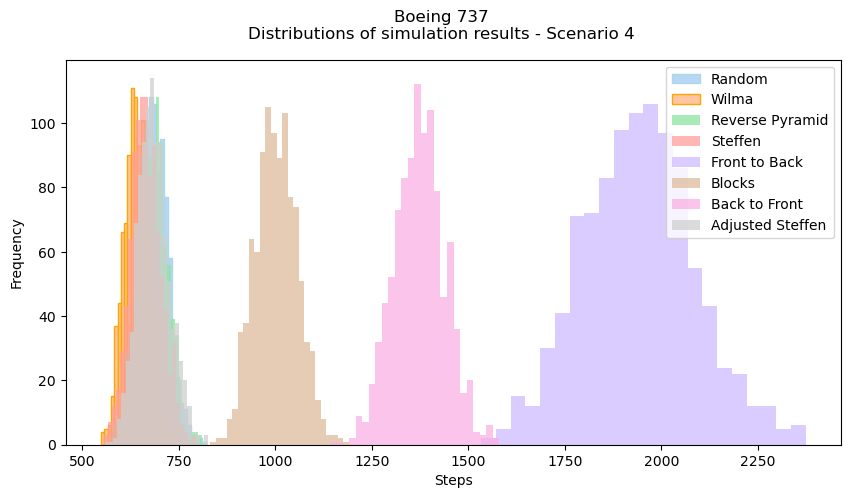

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 737\nDistributions of simulation results - Scenario 4")

sns.histplot(df_737_sc4['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_737_sc4['wilma'], kde=False, label='Wilma', edgecolor = "orange")
sns.histplot(df_737_sc4['reverse pyramid'], kde=False, label='Reverse Pyramid', edgecolor = "none")
sns.histplot(df_737_sc4['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_737_sc4['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_737_sc4['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_737_sc4['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_737_sc4['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

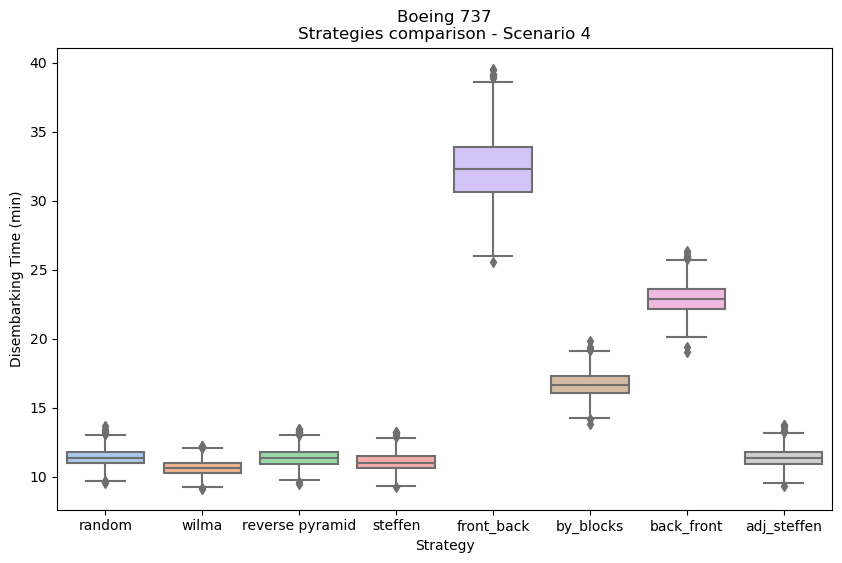

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_737_sc4/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 737\nStrategies comparison - Scenario 4');

### Boeing 737 - Scenario 5 (longer waiting time due to luggage)

In [ ]:
# parameters
air_model = 737
child_fract = 0.1 
old_fract = 0.1
parent_fract = 0.1

# load calibration parameters
with open('calibration.txt', 'r') as f:
    parameters_combinations = [eval(line.rstrip('\n')) for line in f]

In [ ]:
# simulation

tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_wilma = []
tot_steps_count_steffen = []
tot_steps_count_reversepyramid = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_737:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, age_dec = age_dec, parent_dec = parent_dec, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'wilma':
            tot_steps_count_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'reverse pyramid':
            tot_steps_count_reversepyramid.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

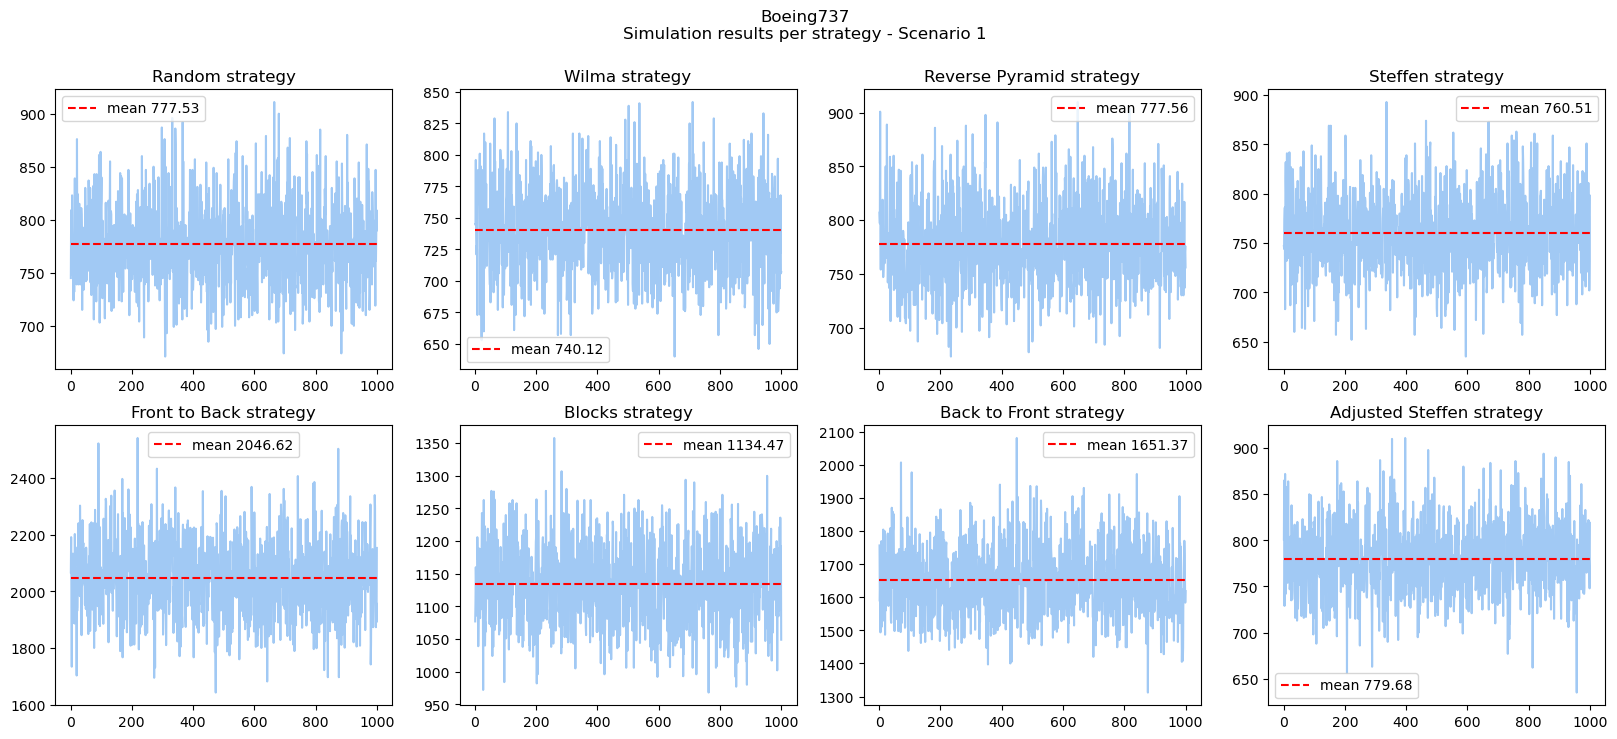

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig. suptitle("Boeing737\nSimulation results per strategy - Scenario 1")
axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_reversepyramid)
axs[0,2].hlines(np.mean(tot_steps_count_reversepyramid), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_reversepyramid):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_steffen)
axs[0,3].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_frontback)
axs[1,0].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_blocks)
axs[1,1].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_backfront)
axs[1,2].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,3].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,3].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[1,3].legend()

axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Wilma strategy')
axs[0,2].set_title('Reverse Pyramid strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');
axs[1,3].set_title('Adjusted Steffen strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_wilma_df = pd.DataFrame(tot_steps_count_wilma, columns=['steps'])
tot_steps_count_revpyramid_df = pd.DataFrame(tot_steps_count_reversepyramid, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_737_sc5 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'wilma': tot_steps_count_wilma_df['steps'], 'reverse pyramid': tot_steps_count_revpyramid_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_737_sc5.to_csv('737_sc5_sim_results.csv')
df_737_sc5

,random,wilma,reverse pyramid,steffen,front_back,by_blocks,back_front,adj_steffen


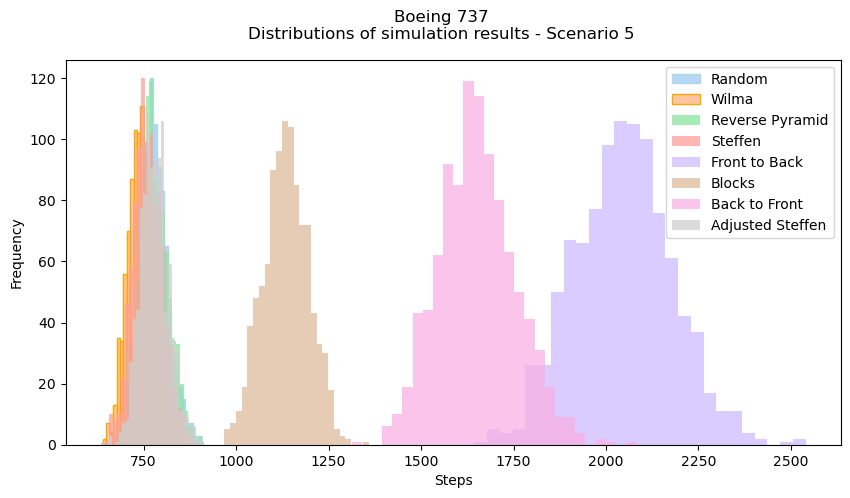

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 737\nDistributions of simulation results - Scenario 5")

sns.histplot(df_737_sc5['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_737_sc5['wilma'], kde=False, label='Wilma', edgecolor = "orange")
sns.histplot(df_737_sc5['reverse pyramid'], kde=False, label='Reverse Pyramid', edgecolor = "none")
sns.histplot(df_737_sc5['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_737_sc5['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_737_sc5['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_737_sc5['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_737_sc5['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

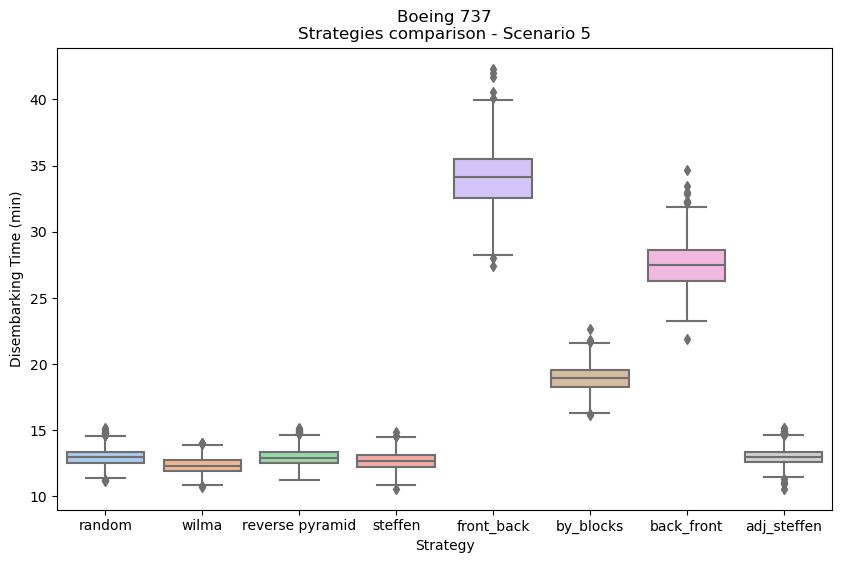

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_737_sc5/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 737\nStrategies comparison - Scenario 5');

Boeing 777 - Scenario 3 (higher percentage of family groups)

In [ ]:
# parameters
air_model = 777
child_fract = 0.35 # <-- updated parameter
old_fract = 0.1 
parent_fract = 0.35 # <-- updated parameter

In [ ]:
# simulation

tot_steps_count_adj_steffen = []
tot_steps_count_random = []
tot_steps_count_adj_wilma = []
tot_steps_count_steffen = []
tot_steps_count_frontback = []
tot_steps_count_backfront = []
tot_steps_count_blocks = []

for strategy in strategies_777:
    
    for n in range(1000):
        luggage_fract, age_dec, parent_dec = random.choice(parameters_combinations)
        model = AircraftModel(aircraft_model = air_model, luggage_fract=luggage_fract, child_fract=child_fract, old_fract=old_fract, parent_fract=parent_fract, strategy=strategy)
        passengers_count = np.zeros((model.grid.width, model.grid.height)) 
        removed_agents = []
        

        i = 1
        while len(model.schedule.agents) > 0:
            model.step()
            i += 1
            
            removed_agents_count = model.agents_removed
            removed_agents.append(removed_agents_count)
        
        if strategy == 'adjusted steffen':
            tot_steps_count_adj_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'random':
            tot_steps_count_random.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'adjusted wilma':
            tot_steps_count_adj_wilma.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'steffen':
            tot_steps_count_steffen.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'front_back':
            tot_steps_count_frontback.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'back_front':
            tot_steps_count_backfront.append(len(model.datacollector.get_model_vars_dataframe()))
        elif strategy == 'blocks':
            tot_steps_count_blocks.append(len(model.datacollector.get_model_vars_dataframe()))
    
    print(f'{strategy}: DONE')

random: DONE
adjusted wilma: DONE
steffen: DONE
adjusted steffen: DONE
front_back: DONE
back_front: DONE
blocks: DONE


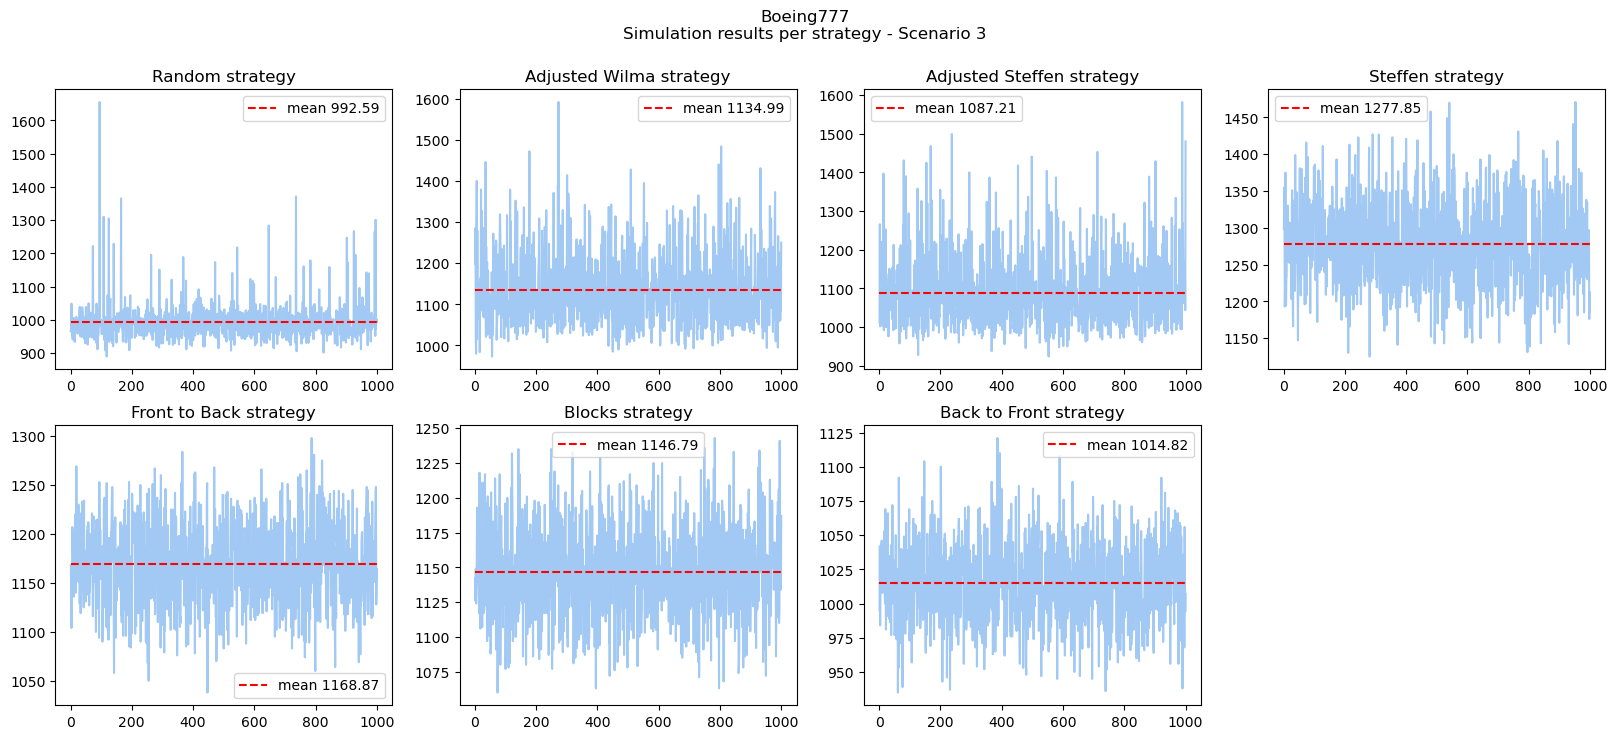

In [ ]:
from matplotlib.pyplot import hlines

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.delaxes(axs[1,3])
fig.suptitle("Boeing777\nSimulation results per strategy - Scenario 3")

axs[0,0].plot(range(1,1001),tot_steps_count_random)
axs[0,0].hlines(np.mean(tot_steps_count_random), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_random):.2f}')
axs[0,1].plot(range(1,1001),tot_steps_count_adj_wilma)
axs[0,1].hlines(np.mean(tot_steps_count_adj_wilma), 0, 1000, colors='r', linestyles='dashed', label = f'mean {np.mean(tot_steps_count_adj_wilma):.2f}')
axs[0,2].plot(range(1,1001),tot_steps_count_steffen)
axs[0,2].hlines(np.mean(tot_steps_count_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_steffen):.2f}')
axs[0,3].plot(range(1,1001),tot_steps_count_frontback)
axs[0,3].hlines(np.mean(tot_steps_count_frontback), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_frontback):.2f}')
axs[1,0].plot(range(1,1001),tot_steps_count_blocks)
axs[1,0].hlines(np.mean(tot_steps_count_blocks), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_blocks):.2f}')
axs[1,1].plot(range(1,1001),tot_steps_count_backfront)
axs[1,1].hlines(np.mean(tot_steps_count_backfront), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_backfront):.2f}')
axs[1,2].plot(range(1,1001),tot_steps_count_adj_steffen)
axs[1,2].hlines(np.mean(tot_steps_count_adj_steffen), 0, 1000, colors='r', linestyles='dashed', label=f'mean {np.mean(tot_steps_count_adj_steffen):.2f}')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[0,3].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()


axs[0,0].set_title('Random strategy')
axs[0,1].set_title('Adjusted Wilma strategy')
axs[0,2].set_title('Adjusted Steffen strategy')
axs[0,3].set_title('Steffen strategy')
axs[1,0].set_title('Front to Back strategy')
axs[1,1].set_title('Blocks strategy')
axs[1,2].set_title('Back to Front strategy');

In [ ]:
import pandas as pd
# transform tot_steps_count into a df
tot_steps_count_random_df = pd.DataFrame(tot_steps_count_random, columns=['steps'])
tot_steps_count_adj_wilma_df = pd.DataFrame(tot_steps_count_adj_wilma, columns=['steps'])
tot_steps_count_steffen_df = pd.DataFrame(tot_steps_count_steffen, columns=['steps'])
tot_steps_count_frontback_df = pd.DataFrame(tot_steps_count_frontback, columns=['steps'])
tot_steps_count_blocks_df = pd.DataFrame(tot_steps_count_blocks, columns=['steps'])
tot_steps_count_adj_steffen_df = pd.DataFrame(tot_steps_count_adj_steffen, columns=['steps'])
tot_steps_count_backfront_df = pd.DataFrame(tot_steps_count_backfront, columns=['steps'])

In [ ]:
df_777_sc3 = pd.DataFrame({'random': tot_steps_count_random_df['steps'], 'adj_wilma': tot_steps_count_adj_wilma_df['steps'], 'steffen': tot_steps_count_steffen_df['steps'], 'front_back': tot_steps_count_frontback_df['steps'], 'by_blocks': tot_steps_count_blocks_df['steps'], 'back_front': tot_steps_count_backfront_df['steps'], 'adj_steffen': tot_steps_count_adj_steffen_df['steps']})
df_777_sc3.to_csv('777_sc3_sim_results.csv')
df_777_sc3

,random,adj_wilma,steffen,front_back,by_blocks,back_front,adj_steffen
0,966,1199,1012,1299,1168,1142,995
1,972,1286,1266,1355,1140,1126,1042
2,1049,1016,1002,1304,1104,1149,984
3,1012,980,1032,1193,1143,1124,1023
4,953,1248,1097,1217,1156,1134,1008
...,...,...,...,...,...,...,...
995,1301,1204,1065,1297,1243,1159,968
996,973,1061,1149,1287,1248,1156,1056
997,1004,1227,1165,1176,1128,1169,1015
998,1002,1085,1044,1213,1146,1134,994


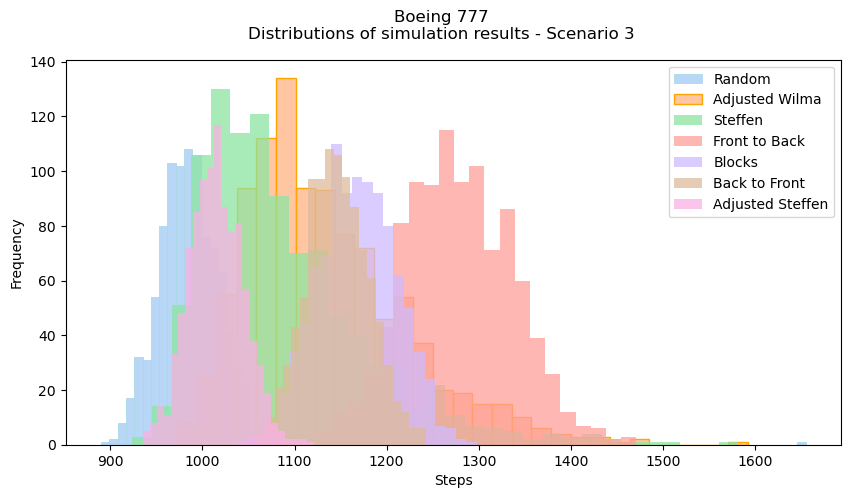

In [ ]:
import seaborn as sns

sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Boeing 777\nDistributions of simulation results - Scenario 3")
sns.histplot(df_777_sc3['random'], kde=False, label='Random', edgecolor =  "lightblue")
sns.histplot(df_777_sc3['adj_wilma'], kde=False, label='Adjusted Wilma', edgecolor = "orange")
sns.histplot(df_777_sc3['steffen'], kde=False, label='Steffen', edgecolor = "none")
sns.histplot(df_777_sc3['front_back'], kde=False, label='Front to Back', edgecolor = "none")
sns.histplot(df_777_sc3['by_blocks'], kde=False, label='Blocks', edgecolor = "none")
sns.histplot(df_777_sc3['back_front'], kde=False, label='Back to Front', edgecolor = "none")
sns.histplot(df_777_sc3['adj_steffen'], kde=False, label='Adjusted Steffen', edgecolor = "none")

plt.xlabel('Steps')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show();

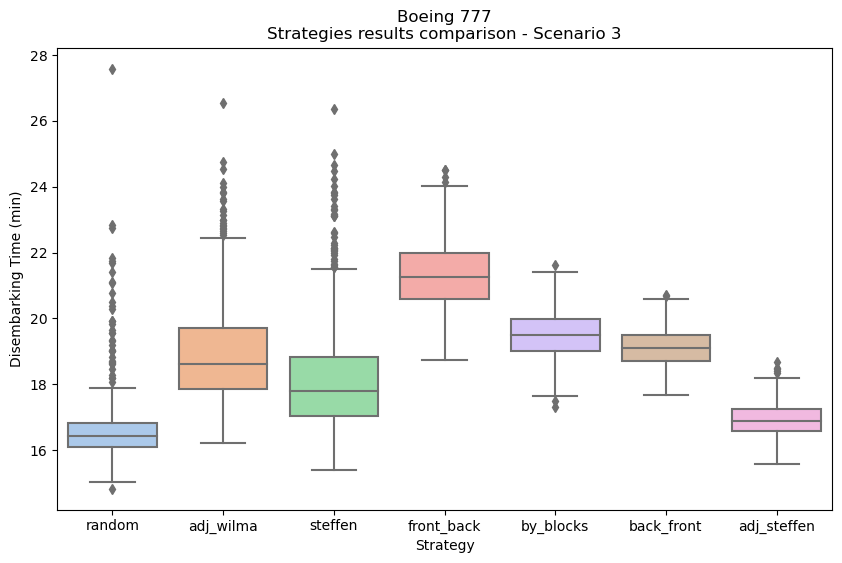

In [ ]:
# plot boxplots of the 4 strategies
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_777_sc3/60, palette="pastel")
plt.xlabel("Strategy") 
plt.ylabel("Disembarking Time (min)")
plt.title('Boeing 777\nStrategies results comparison - Scenario 3');